# MS-E2121 Exercise session 6

### Problem 6.1: Sensitivity analysis in the RHS

Consider the following LP and its optimal tableau below:

\begin{matrix}
		min         &  -2x_1  & - &   x_2  & + &  x_3  &       &    \\
		s.t.        &    x_1  & + &  2x_2  & + &  x_3  &  \leq & 8  \\
		            &   -x_1  & + &   x_2  & - & 2x_3  &  \leq & 4  \\
		            &   3x_1  & + &   x_2  &   &       &  \leq & 10 \\
            &    x_1, x_2, x_3  & \geq & 0   
\end{matrix}

<br/>

\begin{matrix}
      & | & \text{RHS} & | &    x_1 &   x_2 &   x_3  &   x_4  &   x_5  &   x_6  \\
 z=   & | &       -7.6 & | &      0 &     0 &   1.2  &   0.2  &     0  &   0.6  \\
 --   & | &        --- & | &    --- &   --- &   ---  &   ---  &    --- &    --- \\
x_1 = & | &        2.4 & | &      1 &     0 &  -0.2  &  -0.2  &     0  &   0.4  \\
x_2 = & | &        2.8 & | &      0 &     1 &   0.6  &   0.6  &     0  &  -0.2  \\
x_5 = & | &        3.6 & | &      0 &     0 &  -2.8  &  -0.8  &     1  &   0.6  \\
\end{matrix}

(a) If you were to choose between increasing in 1 unit the right hand side (RHS) of any constraints, which one would you choose, and why? What is the effect of the increase on the optimal cost? <br/>
<br/>
(b) Perform a sensitivity analysis on the model to discover what is the range of alteration in the RHS in which the same effect calculated in item (a) can be expected. *HINT*: JuMP 0.21.6 and above includes the function ``lp_sensitivity_report()`` that you can use to help performing the analysis.

In [1]:
using JuMP, GLPK

Matrices A, b, and c:

In [2]:
A = [ 1  2  1  1  0  0;
     -1  1 -2  0  1  0;
      3  1  0  0  0  1]

b = [8 ; 4 ; 10]
c = [-2 ; -1 ; 1 ; 0 ; 0 ; 0];

Using the optimal solution presented in the optimal tableau ($x_1 = 2.4$, $x_2 = 2.8$, $x_5 = 3.6$), we can check what is the optimal basis. Additionally, columns $A_4$, $A_5$, and $A_6$ stand for the slack variables. 

In [3]:
Bas = [1,2,5]
## Computing invB
B = A[:,Bas]
invB = inv(B);

In [4]:
invB

3×3 Array{Float64,2}:
 -0.2  -0.0   0.4
  0.6  -0.0  -0.2
 -0.8   1.0   0.6

Using the reduced costs from the optimal tableau, we can derive the duals $p_1, p_2, p_3$ as follows: <br/>
<br/>
$\bar{c}_j = c_j - c_B B^{-1} A_j = c_j - p^{\top}A_j$ <br/>

$0.2 = \bar{c}_4 = c_4 - \text{p}^{\top}\text{A}_4 = 0 - p_1 \Rightarrow p_1 = -0.2$ <br/>
$0 = \bar{c}_5 = c_5 - \text{p}^{\top}\text{A}_5 = 0 - p_2 \Rightarrow p_2 = 0$ <br/>
$0.6 = \bar{c}_6 = c_6 - \text{p}^{\top}\text{A}_6 = 0 - p_3 \Rightarrow p_3 = -0.6$ <br/>

Therefore, the effects on the optimal cost for increasing in 1 the RHS of the constraints $c_1, c_2, c_3$ is respectively $(-0.2,0,-0.6)$.

As shown in Lecture 6, slide 10, the bounds for the RHS alteration $\delta$ is: <br/>
<br/>
${max}_{j:g_{ji}>0} \left( -\frac{x_{\text{B(j)}}}{g_{ji}} \right) \leq \delta \leq {min}_{j:g_{ji}<0} \left( -\frac{x_{\text{B(j)}}}{g_{ji}} \right)$,

where $g_{ji}$ is the element on the $j$th row and $i$th column of $B^{-1}$.

In [5]:
x_B = invB*b # Could also just get this from the optimal tableau

3-element Array{Float64,1}:
 2.3999999999999995
 2.8
 3.5999999999999988

In [6]:
## Computing the range of changing for the constraint 1
bounds = -x_B./invB[:,1]
g_pos = invB[:,1] .> 0
g_neg = invB[:,1] .< 0

lower_bound_1 = maximum(bounds[g_pos])
upper_bound_1 = minimum(bounds[g_neg]);

println("Changes in the RHS for c1 are constrained between [", round(lower_bound_1,digits=2) , "," ,
        round(upper_bound_1,digits=2), "]." )
println("b_1 is thus constrained between [", b[1]+round(lower_bound_1,digits=2) , "," ,
        b[1]+round(upper_bound_1,digits=2), "]." )

Changes in the RHS for c1 are constrained between [-4.67,4.5].
b_1 is thus constrained between [3.33,12.5].


In [7]:
## Computing the range of changing for the constraint 3
bounds = -x_B./invB[:,3]
g_pos = invB[:,3] .> 0
g_neg = invB[:,3] .< 0

lower_bound_3 = maximum(bounds[g_pos])
upper_bound_3 = minimum(bounds[g_neg]);

println("Changes in the RHS for c3 are constrained between [", round(lower_bound_3,digits=2) , "," ,
        round(upper_bound_3,digits=3), "]." )
println("b_3 is thus constrained between [", b[3]+round(lower_bound_3,digits=2) , "," ,
        b[3]+round(upper_bound_3,digits=2), "]." )

Changes in the RHS for c3 are constrained between [-6.0,14.0].
b_3 is thus constrained between [4.0,24.0].


We can do the same using JuMP:

In [8]:
## Declaring the model
model = Model(GLPK.Optimizer);

In [9]:
## Developing the LP

## Declaring variables
@variable(model, x1 >= 0)
@variable(model, x2 >= 0)
@variable(model, x3 >= 0)

## Declaring objective function
@objective(model, Min, -2x1 - x2 + x3)

## Declaring constraints
@constraint(model, con1, x1 + 2x2 + x3 <= 8)
@constraint(model, con2, -x1 + x2 -2x3 <= 4)
@constraint(model, con3, 3x1 + x2 <= 10);

In [10]:
## Solving the LP
set_silent(model)
optimize!(model)
status = termination_status(model);
print(status)

OPTIMAL

In [11]:
## Storing the optimal point
optimal_point = value.([x1 , x2 , x3]);

In [12]:
## Storing the obj function at the original optimal point
obj = objective_value(model);

In [13]:
## Storing dual relative to each constraint
duals = [dual(con1) , dual(con2) , dual(con3)];

The function ``lp_sensitivity_report()``, introduced in JuMP 0.21.6, returns objects mapping either the range in which a variable's coefficient in the OF can change without changing the optimal basis or the RHS sensitivity. More details at https://jump.dev/JuMP.jl/dev/reference/solutions/#JuMP.lp_sensitivity_report.

In [14]:
report = lp_sensitivity_report(model);

This sensitivity report includes two dictionaries:
- ```rhs``` contains the RHS bounds for each constraint, including nonnegativity constraints
- ```objective``` contains the bounds for each objective function coefficient

In [15]:
println("Allowable decrease/increase for the RHS of each named constraint:")
for con in keys(report.rhs)
    if name(con) != ""
        println("$(name(con)) => $(round.(report[con],digits=2))")
    end
end
println("\nAllowable decrease/increase for each objective function coefficient:")
for var in keys(report.objective)
    println("$(name(var)) => $(round.(report[var],digits=2))")
end

Allowable decrease/increase for the RHS of each named constraint:
con1 => (-4.67, 4.5)
con2 => (-3.6, Inf)
con3 => (-6.0, 14.0)

Allowable decrease/increase for each objective function coefficient:
x2 => (-3.0, 0.33)
x1 => (-1.0, 1.5)
x3 => (-1.2, Inf)


We can use this report to print our results in a prettier format:

In [16]:
## Checking how the objective function can be altered with the RHS
for i in 1:3
    if duals[i] == 0
        println("Constraint $i is not binding.")
    else
        println("Constraint $i is binding, \nincreasing one unit on the RHS will change the optimal value by ", duals[i],
            " if b stays between [", b[i]+round(report[[con1,con2,con3][i]][1],digits = 2), " , ", b[i]+round(report[[con1,con2,con3][i]][2],digits = 2), "].")
    end
end

Constraint 1 is binding, 
increasing one unit on the RHS will change the optimal value by -0.2 if b stays between [3.33 , 12.5].
Constraint 2 is not binding.
Constraint 3 is binding, 
increasing one unit on the RHS will change the optimal value by -0.6 if b stays between [4.0 , 24.0].


### Problem 6.4: Adding a new constraint

Given the LP below,

\begin{matrix}
		max         &   2x_1  & + &   x_2  &            \\
		s.t.        &   2x_1  & + &  2x_2  &  \leq & 9  \\
		            &   2x_1  & - &   x_2  &  \leq & 3  \\
		            &    x_1  &   &        &  \leq & 3  \\
		            &         &   &   x_2  &  \leq & 4  \\
                    &    x_1, x_2, x_3  & \geq & 0   
\end{matrix}

(a) Find the primal and dual optimal solutions. *HINT*: You can use complementary slackness to, once having the primal optimum, finding the dual optimal solution. <br/>
<br/>
(b) Suppose we add a new constraint $6x_1 - x_2 \leq 6$, classify the primal and dual former optimal points saying if they: (i) keep being optimal ; (ii) turn to be feasible but not optimal ; or (iii) turn infeasible.<br/>
<br/>
(c) Consider the new problem from item (b), find the new dual optimal point through one dual simplex iteration. After that, find the primal optimum using *complementary slackness*.

In [17]:
using Plots
using LinearAlgebra

#### (a)

In [18]:
A = [2.0 2.0 ; 2.0 -1.0 ; 1.0 0.0 ; 0.0 1.0]           # Constraints coefficients matrix
b = [9.0 ; 3.0 ; 3.0 ; 4.0]                            # RHS
c = [2.0 ; 1.0];                                       # OF's coefficients

In [19]:
## Changing the problem to standard form
A_p = Matrix(hcat(A,I(4))) # I(4) is an identity matrix representing the slack variable coefficients
b_p = copy(b)              # RHS doesn't change
c_p = vcat(-c,zeros(4));   # Slack variables have objective coefficient zero

In [20]:
#%
## Computing invB
Bas_p = [1,2,5,6]
B_p = A_p[:,Bas_p]
invB_p = inv(B_p);
#%

In [21]:
#%
## Computing the primal optimum
xB_p = invB_p*b_p              # solution including slack variables values
optimal_point_p = xB_p[1:2]    # optimal point in 2D
#%

2-element Array{Float64,1}:
 2.5
 2.0

In [22]:
#%
## Computing the dual optimum
duals = (c_p[Bas_p]'*invB_p)'
#%

4-element Array{Float64,1}:
 -0.6666666666666667
 -0.3333333333333333
  0.0
  0.0

#### (b)

Adding the constraint $6x_1-x_2 \le 6$, we can see that our primal solution $[2.5, 2]$ does not satisfy the constraint. The primal solution thus turns infeasible. On the dual side, this is equivalent to adding a variable, and we know that does not cause infeasibility. However, since the primal solution becomes infeasible, the corresponding dual solution cannot remain optimal.

#### (c)

New constraint: 6x1 - x2 <= 6

In [23]:
## Writing the new constraint coefficient vector
#%
a_new = [6 ; -1 ; 0 ; 0 ; 0 ; 0];
#%

New matrix A: \begin{bmatrix}
    \textbf{A}          & \textbf{0} \\
    \textbf{a}^\top _{m+1}   &  1
\end{bmatrix}

In [24]:
## Updating A
#%
A = hcat( vcat(A_p , a_new') , [zeros(size(A_p)[1]) ; 1] )
#%

5×7 Array{Float64,2}:
 2.0   2.0  1.0  0.0  0.0  0.0  0.0
 2.0  -1.0  0.0  1.0  0.0  0.0  0.0
 1.0   0.0  0.0  0.0  1.0  0.0  0.0
 0.0   1.0  0.0  0.0  0.0  1.0  0.0
 6.0  -1.0  0.0  0.0  0.0  0.0  1.0

New matrix B: 

$\bar{\text{B}} =$
\begin{bmatrix}
    \text{B}      &  \text{0} \\
    \text{a}^\top &  1
\end{bmatrix}

In [25]:
## Updating B
#%
B = hcat( vcat(B_p , a_new[Bas_p]') , [zeros(size(B_p)[1]) ; 1] )
#%

5×5 Array{Float64,2}:
 2.0   2.0  0.0  0.0  0.0
 2.0  -1.0  0.0  0.0  0.0
 1.0   0.0  1.0  0.0  0.0
 0.0   1.0  0.0  1.0  0.0
 6.0  -1.0  0.0  0.0  1.0

New matrix invB: 

$\bar{\text{B}}^{\ -1} =$
\begin{bmatrix}
    \text{B}^{\ -1}           &  \text{0} \\
    -\text{a}^\top \text{B}^{\ -1}  &   1
\end{bmatrix}

In [26]:
## Updating B⁻¹
#%
invB = hcat( vcat(invB_p , -a_new[Bas_p]'*invB_p) , [zeros(size(invB_p)[1]) ; 1] )
#%

5×5 Array{Float64,2}:
  0.166667   0.333333  0.0  -0.0  0.0
  0.333333  -0.333333  0.0  -0.0  0.0
 -0.166667  -0.333333  1.0  -0.0  0.0
 -0.333333   0.333333  0.0   1.0  0.0
 -0.666667  -2.33333   0.0   0.0  1.0

In [27]:
## Updating c
#%
c = [ c_p ; 0 ]
#%

7-element Array{Float64,1}:
 -2.0
 -1.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [28]:
## Updating the basis
#%
Bas = [Bas_p ; 7]
#%

5-element Array{Int64,1}:
 1
 2
 5
 6
 7

In [29]:
## Forming the reduced costs
#%
cr = c' - c[Bas]'*invB*A
#%

1×7 Adjoint{Float64,Array{Float64,1}}:
 0.0  2.22045e-16  0.666667  0.333333  0.0  0.0  0.0

In [30]:
## Updating b
#%
b = [b_p ; 6]
#%

5-element Array{Float64,1}:
 9.0
 3.0
 3.0
 4.0
 6.0

In [31]:
## New solution (with x7 in the basis)
#%
x_B = invB*b
#%

5-element Array{Float64,1}:
  2.5
  2.0
  0.4999999999999998
  2.0
 -7.0

#### (c)

In [32]:
#%
## Forming the tableau to analyse the dual simplex direction
tableau = round.(hcat([0 ; x_B] , vcat(cr , invB*A)),digits = 2)
#%

6×8 Array{Float64,2}:
  0.0  0.0   0.0   0.67   0.33  0.0  0.0  0.0
  2.5  1.0   0.0   0.17   0.33  0.0  0.0  0.0
  2.0  0.0   1.0   0.33  -0.33  0.0  0.0  0.0
  0.5  0.0  -0.0  -0.17  -0.33  1.0  0.0  0.0
  2.0  0.0   0.0  -0.33   0.33  0.0  1.0  0.0
 -7.0  0.0   0.0  -0.67  -2.33  0.0  0.0  1.0

For visualisation:

\begin{equation*}
  \begin{array}{r|c|ccccccc}
          &  \text{RHS} &    x_1 &    x_2 &    x_3 &               x_4 &   x_5  &   x_6  &   x_7   \\
          &           0 &      0 &      0 &   0.67 &              0.33 &     0  &     0  &     0   \\
    \hline
    x_1 = &         2.5 &      1 &      0 &   0.17 &              0.33 &     0  &     0  &     0   \\
    x_2 = &           2 &      0 &      1 &   0.33 &             -0.33 &     0  &     0  &     0   \\
    x_5 = &         0.5 &      0 &      0 &  -0.17 &             -0.33 &     1  &     0  &     0   \\
    x_6 = &           2 &      0 &      0 &  -0.33 &              0.33 &     0  &     1  &     0   \\
    x_7 = &          -7 &      0 &      0 &  -0.67 & \color{red}{-2.33}&     0  &     0  &     1   \\
  \end{array}
\end{equation*}

In [33]:
#%
## New basis: [1,2,5,6,4]
Bas = [1,2,5,6,4]
B = A[:,Bas]
invB = inv(B);
#%

In [34]:
#%
## Compute and store the new solution
x_B = invB*b
#%

5-element Array{Float64,1}:
 1.5
 2.9999999999999996
 1.5
 1.0000000000000004
 3.0

In [35]:
#%
## New optimality check
cr = c' .- c[Bas]'*invB*A
#%

1×7 Array{Float64,2}:
 0.0  0.0  0.571429  0.0  0.0  0.0  0.142857

In [36]:
#%
optimal_point = round.(x_B[1:2], digits=2)
#%

2-element Array{Float64,1}:
 1.5
 3.0

#### Visualisation

In [37]:
#%
## Create functions to plot later
c1(x) = 4.5 - x                                   # Constraint 1
c2(x) = -3 + 2x                                   # Constraint 2
c3(x) = -6 + 6x                                   # Constraint 3 (extra constraint)
zf1(x) = (dot([2,1], optimal_point_p) - 2x);      # OF (first optimal point)
zf2(x) = (dot([2,1], optimal_point) - 2x);        # OF (optimal point after the added constraint)

# Range to with the function (constraint) is defined in the plot
x = range(0,4,length=2);                          # between [0,4]
#%

In [38]:
#%
## Defining the colors to be used
c_blue = palette(:auto)[1]                         # color :1
c_orange = palette(:auto)[2]                       # color :2
c_green = palette(:auto)[3];                       # color :3
#%

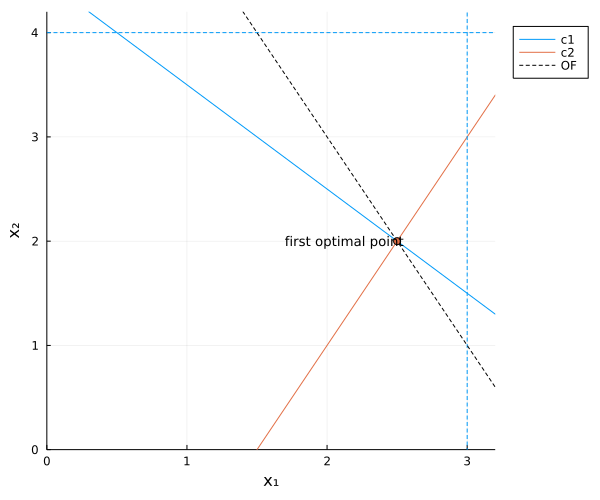

In [39]:
#%
## Plotting constraints
plot(x, c1.(x),
    xaxis = ("x₁", (0,3.2)),
    yaxis = ("x₂", (0,4.2)),
    size = (600,500),
    label = "c1",
    legend = :outertopright
)
plot!(x, c2.(x), label = "c2")

## Plotting bounds
vline!([3], line = :dash, label = "", color = c_blue)        # put label as "" to not appear in the legend
hline!([4], line = :dash, label = "", color = c_blue)        

## Plotting OF @ optimal point
plot!(x, zf1.(x), line = :dash, color = :black, label="OF")

## Plotting the optimal point
scatter!([optimal_point_p[1]], [optimal_point_p[2]], color = c_orange, label="")
annotate!(optimal_point_p[1]-0.8, optimal_point_p[2], ("first optimal point", 9, :left))
#%

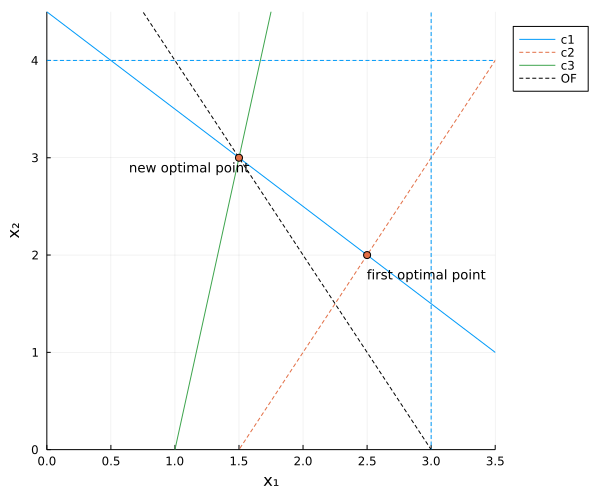

In [40]:
#%
## Plotting constraints
plot(x, c1.(x),
    xaxis = ("x₁", (0,3.5)),
    yaxis = ("x₂", (0,4.5)),
    size = (600,500),
    label = "c1",
    legend = :outertopright
)
plot!(x, c2.(x), line = :dash, label = "c2")
plot!(x, c3.(x), label = "c3")

## Plotting bounds
vline!([3], line = :dash, label = "", color = c_blue)        # put label as "" to not appear in the legend
hline!([4], line = :dash, label = "", color = c_blue)        

## Plotting OF @ optimal point
plot!(x, zf2.(x), line = :dash, color = :black, label="OF")

## Plotting original optimum
scatter!([optimal_point_p[1]], [optimal_point_p[2]], color = c_orange, label="")
annotate!(optimal_point_p[1], optimal_point_p[2]-0.2, ("first optimal point", 9, :left))

## Plotting new optimum
scatter!([optimal_point[1]], [optimal_point[2]], color = c_orange, label="")
annotate!(optimal_point[1]-0.85, optimal_point[2]-0.1, ("new optimal point", 9, :left))
#%

Checking with JuMP

In [41]:
#%
## Modelling
m = Model(GLPK.Optimizer)                                # Primal problem

## Var
@variable(m, x[1:2] >= 0)                                # Variables vector
@objective(m, Min, c[1:2]'*x)                            # OF
@constraint(m, cm[i in 1:4] , A[i,1:2]'*x <= b[i])       # Constraints definitions

## Solving and printing
# set_silent(m)
optimize!(m)
println("Optimal cost: ", objective_value(m))
println("x_opt = ", value.(x))

## TODO: Store the optimal cost, optimal point, and duals
obj = objective_value(m)
optimal_point = value.(x)
duals = dual.(cm);
#%

Optimal cost: -7.0
x_opt = [2.5, 2.0]


In [42]:
#%
## TODO: Declare the new constraint
@constraint(m, cm_new, 6x[1] - x[2] <= 6);
#%

In [43]:
#%
## Solving and printing the new model
print(m)
set_silent(m)
optimize!(m)
println("\nNew optimal cost: ", objective_value(m))
println("x_opt = ", round.(value.(x),digits=2))

## Storage of optimal cost, optimal point, and duals
new_obj = objective_value(m)
new_optimal_p = value.(x)
new_duals = [dual.(cm) ; dual(cm_new)];
#%


New optimal cost: -6.0
x_opt = [1.5, 3.0]
